# Reporte técnico: Modelos de riesgo de crédito

Integrantes

- Juan Esteban Ochoa Gómez

- Juan David Correa Arango

- Dioselin Esteban Brito

- Guillermo Álvarez Morales

- Santiago Salazar Ramírez

## Introducción 
El incumplimiento de las obligaciones financieras por parte de los clientes es un temor y una molestia para la mayoría de los bancos, dado que este tipo de situaciones generan que se presente un activo improductivo (NPA) alto, conduciendo a que el banco presente enormes pérdidas financieras, lo que fácilmente se puede traducir en una reducción de la tasa de interés sobre el depósito. Estas situaciones han incentivado a los bancos a crear diferentes técnicas para diferenciar entre el cliente que cumplirá con sus obligaciones y el que no lo hará y de esta manera reducir la probabilidad de pérdida de la compañía proveniente de las dimensiones del valor de sus activos como consecuencia de que un deudor o contra parte incumpla con sus obligaciones.

La forma en que los bancos determinan el riesgo de crédito es evaluando a los clientes a través de sus activos fijos, el valor económico y la calidad de estos. De esta manera realizan un respectivo análisis en donde se evalúa la probabilidad de que el dinero otorgado sea devuelto considerando tanto aspectos cualitativos como cuantitativos.

El problema principal a tratar en este proyecto es identificar qué tan probable es que un cliente no cumpla con sus obligaciones financieras en los siguientes 12 meses a la fecha de originar su crédito. Para el desarrollo del problema es importante tener presente que la variable default (incumplimiento de las obligaciones financieras) está dada en la columna loan_status del archivo adjunto. Se considera que un cliente incumple si está en default o si tiene un atraso de más de 30 días en su pago (en Colombia es usual considerar el default como un atraso de 90 días para la mayoría de los productos de consumo). Lo importante es poder crear un modelo que permita estimar cuando una persona tiene alta probabilidad de incumplir con sus obligaciones financieras y así evitar que el banco presente enormes pérdidas a futuro.

El método a emplear para atacar esta problemática será el uso de regresión logística, que luego con los coeficientes entregados por este método se realiza el scorecard y la probabilidad de que un cliente incumpla con sus obligaciones (esta probabilidad tiene como base el scorecard).



## Metodología

Para el desarrollo o la construcción de un producto que encapsule una posible solución a la problemática descrita, se llevarán a cabo los siguientes pasos:

1. Preparación de los datos: Eliminación de columnas con gran cantidad de valores nulos, selección de variables categóricas y continuas.

undefined. Creación de agrupaciones para las variables continuas.

undefined. Realización de weight of evidence e information value

undefined. Creación de la regresión logística.

undefined. Creación del scorecard.

## Desarrollo

In [1]:
# Primer paso: importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

Para la preparación primero debemos importar el Dataset: loan_data_2007_2014.  Esta base contiene la información respecto a las  deudas del 2007 al 2014 con la cual se procederá a realizar el trabajo.  En la Figura 1 se puede visualizar los datos iniciales del dataset.

In [2]:
# Se importa el dataset
loanDataset = pd.read_csv('loan_data_2007_2014.csv')

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3139: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Figura 1. Visualización de los datos 

Dataset: loan_data_2007_2014

In [3]:
loanDataset.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nota: La figura representa las primeras 5 filas del dataset. 

Para una representación correcta de la regresión es importante seleccionar una variable que cumpla la función de variable dependiente. La variable dependiente tomada es loan_status, ya que define si la deuda está en default (incumplimiento de las obligaciones) o no. El loan_status presenta diferentes posibles valores, entonces estos serán transformados para que sean default o no (0 o 1 respectivamente).

#### Valores que presentan incumplimiento (0)
* Charged off
* Default.
* Late (31-120 days).
* Does not meet the credit policy. Status:Charged Off.

#### Valores que representan cumplimiento (1):
* Fully Paid.
* Current.
* In Grace Period:
* Late (16-30 days).
* Does not meet the credit policy. Status:Fully Paid.

In [4]:
# Se copia el dataset para no modificar sobre la original
loanDatasetCopy = loanDataset.copy()

Se procede a realizar la eliminación de las columnas en donde se presenta un porcentaje mayor al 60% en valores que contengan NA, para poder obtener un mejor análisis de los datos y que no haya lugar a resultados poco coherentes . 

In [5]:
# Eliminar las columnas que tengan más del 60% de NA values
perc = 60.0 # Like N %
min_count =  int(((100-perc)/100)*loanDatasetCopy.shape[0] + 1)
loanDatasetCopy = loanDatasetCopy.dropna( axis=1, 
                thresh=min_count)

Ahora procederemos a eliminar las columnas que no aportan ningún tipo de información de interés para el análisis de los datos que nos ayudarán a darle una respuesta a la problemática que se esta abordando.

In [6]:
# Ahora a eliminar las columnas que directamente no aportan información para el análisis
columnasBorrar = ['id','member_id','url','title','zip_code','recoveries','collection_recovery_fee','issue_d']
loanDatasetCopy.drop(columnasBorrar,axis=1,inplace=True)

In [7]:
# Nuestra target value es el loan_status
# Charged Off, Default, Late (31–120 days),Does not meet the credit policy. Status:Charged Off : 0(Malo)
# Los demás: 1 (Bueno)
loanDatasetCopy['loan_status'] = loanDatasetCopy['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0,'Current':1,'Default':0,'Late (31-120 days)':0,'In Grace Period':1,'Late (16-30 days)':1,'Does not meet the credit policy. Status:Fully Paid':1,'Does not meet the credit policy. Status:Charged Off':0})

### Variables Continuas seleccionadas
*   loan_amnt: loan amount (Monto del préstamo)
*   funded_amnt: funded amount (Monto financiado)
*   funded_amnt_inv: funded amount by investors (Monto financiado por inversionistas)
*   int_rate: interest rate (Tasa de interés)
*   installment: monthly payment owed (Pago mensual adeudado)
*   annual_inc: self-reported annual income (Ingresos anuales informados)
*   dti: dti (debt to income) (Relación deuda riesgo)
*   revol_bal: total credit revolving balance (Saldo rotativo de crédito total)
*   revol_util: revolving line utilization rate (Tasa de utilización de la línea renovable)
*   out_prncp: remaining outstanding principal (Capital restante pendiente)
*   out_prncp_inv: remaining outstanding principal by investors (Capital restante pendiente por inversionistas)
*   total_pymnt: payments received (Pagos recibidos)
*   total_pymnt_inv: payments received by investors (Pagos recibidos por inversionistas)
*   total_rec_prncp: principal received (Capital recibido)
*   total_rec_int: interest received (Interés recibido)
*   total_rec_late_fee: late fees received (Cargos por mora recibidos)
*   last_pymnt_amnt: last total payment amount received (Importe del último pago total recibido)
*   tot_coll_amt: total collection amounts ever owed (cantidades totales de cobro alguna vez adeudadas)
*   tot_cur_bal: total current balance (Saldo total actual)
*   total_rev_hi_lim: total revolving high credit/credit limit (Límite de crédito/crédito superior renovable total)

### Variables categóricas seleccionadas
*   term: number of payments on the loan (número de pagos del préstamo)
*   grade: LC assigned loan grade (grado de préstamo asignado en la carta de crédito)
*   sub_grade: LC assigned loan subgrade (subgrado de préstamo asignado en la carta de crédito)
*   emp_title: job title supplied by borrower (cargo proporcionado por el prestatario)
*   emp_length: employment length in years (duración del empleo en años)
*   home_ownership: home ownership status provided by borrower (estado de propiedad de la vivienda proporcionado por el prestatario)
*   verification_status: if income was verified (si se verificó el ingreso)
*   pymnt_plan: if a payment plan has been put in place (si se ha establecido un plan de pago)
*   purpose: category provided by the borrower (categoría proporcionada por el prestatario)
*   addr_state: state provided by the borrower (estado proporcionado por el prestatario)
*   delinq_2yrs: 30+ days past-due incidences of delinquency  for the past 2 years (incidencias de morosidad de más de 30 días en los últimos 2 años)
*   earliest_cr_line: earliest credit line (primera línea de crédito)
*   inq_last_6mths: credit inquiries in past 6 months (consultas de crédito en los últimos 6 meses)
*   mths_since_last_delinq: months since borrower's last delinquency (meses desde la última morosidad del prestatario)
*   open_acc: open credit lines (líneas de crédito abiertas)
*   pub_rec: derogatory public records (registros públicos despectivos)
*   total_acc: total credit lines currently (líneas de crédito totales actualmente)
*   initial_list_status: initial listing status of the loan (estado de cotización inicial del préstamo)
*   last_pymnt_d: last month payment was received (último mes en que se recibió el pago)
*   next_pymnt_d: next scheduled payment date (próxima fecha de pago programada)
*   last_credit_pull_d: the most recent month LC pulled credit (Mes más reciente donde se extrajo una carta de crédito)
*   collections_12_mths_ex_med: collections in 12 months excluding medical collections (cobranzas en 12 meses excluyendo cobranzas médicas)
*   policy_code: publicly available policy_code=1 (disponible públicamente policy_code=1). new products not publicly available policy_code=2 (nuevos productos no disponibles públicamente policy_code=2)
*   application_type: indicates whether the loan is an individual application or a joint application with two co-borrowers (indica si el préstamo es una solicitud individual o una solicitud conjunta con dos coprestatarios)
*   acc_now_delinq: accounts on which the borrower is now delinquent (cuentas en las que el prestatario ahora es moroso)

### Variables que no aportan ningun tipo de información de interés
* id: unique LC assigned ID for the loan listing (ID único asignado a la carta de crédito para el listado de préstamos)
* member_id: unique LC assigned Id for the borrower member (ID único asignado a la carta de crédito para el miembro prestatario)
* url: URL for the LC page with listing data (URL de la página de la cárta de crédito con el listado de datos)
* title: loan title provided by the borrower (título del préstamo proporcionado por el prestatario)
* zip_code: first 3 numbers of the zip code provided by the borrower in the loan application (primeros 3 números del código postal proporcionado por el prestatario en la solicitud de préstamo)
* recoveries: post charge off gross recovery (cargo posterior a la recuperación bruta)
* collection_recovery_fee: collection recovery fee (tasa de cobro post cargo)
* issue_d: month which the loan was funded (mes en que se financió el préstamo)

Nota: La explicación y asignación de los nombres de las variables anteriormente descritas se hace teniendo en cuenta el diccionario de datos alojado en https://data.world/jaypeedevlin/lending-club-loan-data-2007-11/workspace/file?filename=LCDataDictionary.csv

Luego de realizar los pasos anteriores en donde se agrupan las variables continuas y categóricas, además de retirar de la base de datos las variables que no aportan información de interes para el análisis, se procede a dividir el dataset en 4 grupos:

* X_train: Los datos de entrenamiento de las variables independientes.
* y_train: Los datos de entrenamiento de las variable dependiente.
* X_test: Los datos de prueba de las variables independientes.
* y_test: Los datos de prueba de la variable dependiente.



Los datos de entrenamiento van a representar el 70% del dataset, mientras que los de prueba el 30%.

In [8]:
# Dividir las variables en X y Y (Split) Se va a realizar en proporción 70/30
X = list(loanDatasetCopy.columns.copy())
X.remove('loan_status')
X = loanDatasetCopy[X]
y = loanDatasetCopy['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
                                                    random_state = 1, stratify = y)

A continuación procederemos a realizar el reinicio del index de las variables divididas.   

In [9]:
# Se va a reiniciar el index de las variables divididas
# X_train
X_train = X_train.reset_index()
X_train = X_train.drop(['index'],axis=1)
# X_test
X_test = X_test.reset_index()
X_test = X_test.drop(['index'],axis=1)
# y_train
y_train = y_train.reset_index()
y_train = y_train.drop(['index'],axis=1)
y_train = y_train.values.flatten()
# y_test
y_test = y_test.reset_index()
y_test = y_test.drop(['index'],axis=1)
y_test = y_test.values.flatten()

Posteriormente se crean dos listas o arreglos que contienen las variables continuas y las variables categóricas respectivamente, pensando en el uso futuro de dichas estructuras.

In [10]:
# Variables continuas
variablesContinuas = ['loan_amnt'
,   'funded_amnt'
,   'funded_amnt_inv'
,   'int_rate'
,   'installment'
,   'annual_inc'
,   'dti'
,   'revol_bal'
,   'revol_util'
,   'out_prncp'
,   'out_prncp_inv'
,   'total_pymnt'
,   'total_pymnt_inv'
,   'total_rec_prncp'
,   'total_rec_int'
,   'total_rec_late_fee'
,   'last_pymnt_amnt'
,   'tot_coll_amt'
,   'tot_cur_bal'
,   'total_rev_hi_lim']

In [11]:
# Variables categóricas
variablesCategoricas = ['term',
'sub_grade'
,   'grade'
,   'emp_title'
,   'emp_length'
,   'home_ownership'
,   'verification_status'
,   'pymnt_plan'
,   'purpose'
,   'addr_state'
,   'delinq_2yrs'
,   'earliest_cr_line'
,   'inq_last_6mths'
,   'mths_since_last_delinq'
,   'open_acc'
,   'pub_rec'
,   'total_acc'
,   'initial_list_status'
,   'last_pymnt_d'
,   'next_pymnt_d'
,   'last_credit_pull_d'
,   'collections_12_mths_ex_med'
,   'policy_code'
,   'application_type'
,   'acc_now_delinq']

La matriz de correlación de la Figura 2 tiene como objetivo entender la correlación entre las distintas variables continuas que se tienen en cuenta hasta el momento.  Con ayuda de los datos que arroja esta matriz se puede determinar qué variables continuas se deben de eliminar. Dichas variables serán aquellas que presenten una alta correlación.

Figura 2

Matriz de correlación 

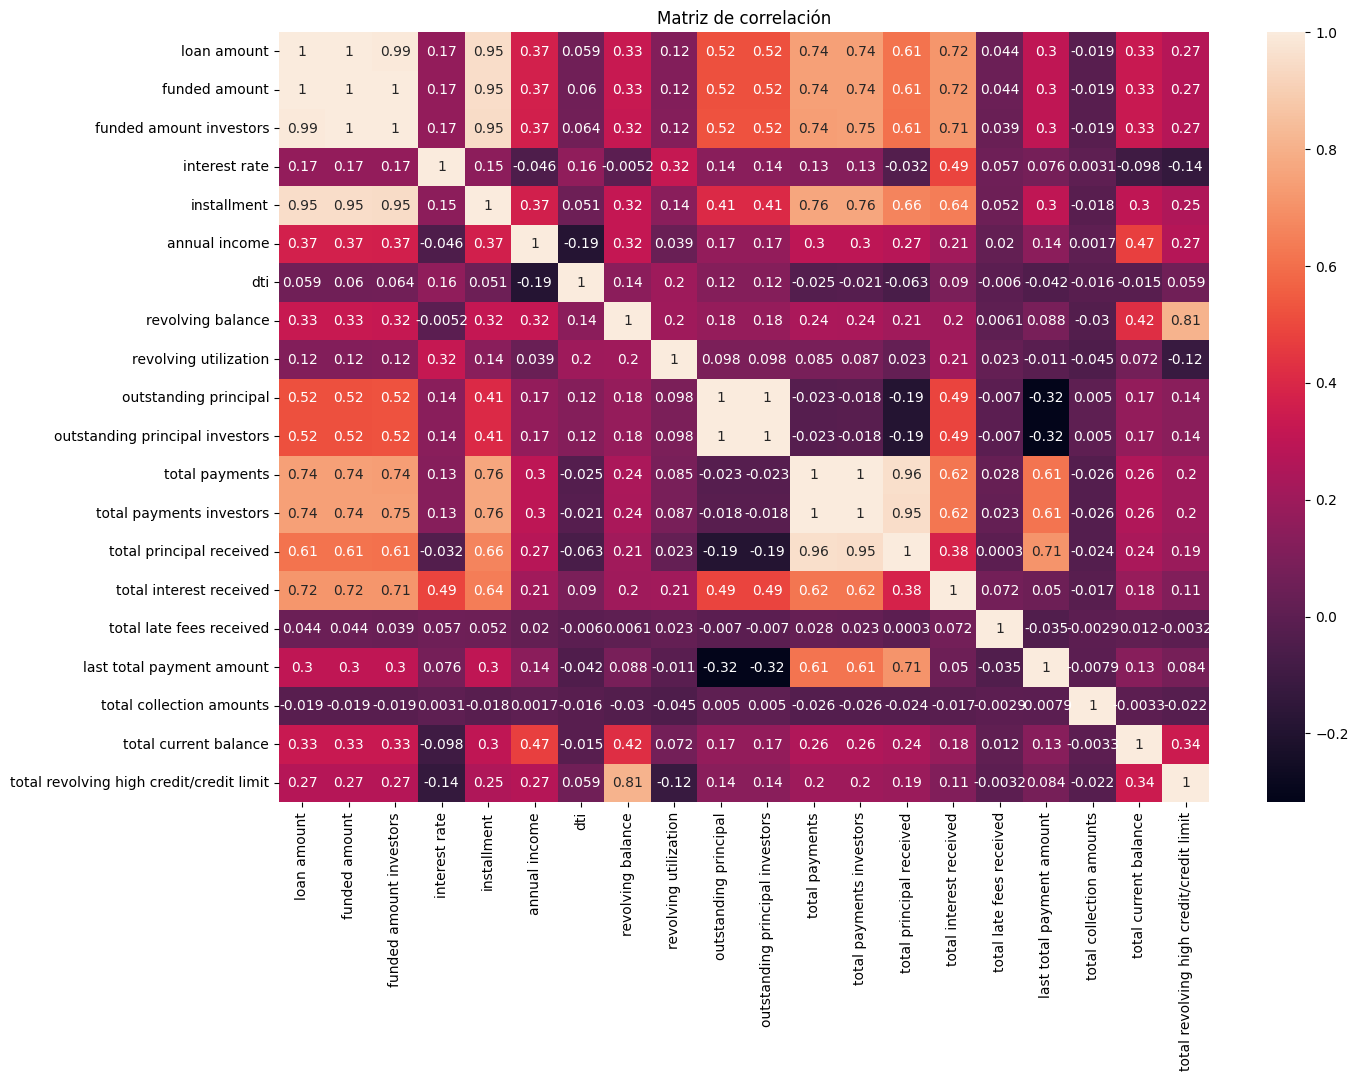

In [12]:
# Vamos a identificar la correlación de  las variables continuas para ver qué variables se deben eliminar
corr_df = X_train[variablesContinuas].corr(method='pearson')
var_NamesNum=[
    'loan amount',
    'funded amount',
    'funded amount investors',
    'interest rate', 
    'installment',
    'annual income', 
    'dti', 
    'revolving balance',
    'revolving utilization', 
    'outstanding principal', 
    'outstanding principal investors',
    'total payments',
    'total payments investors',
    'total principal received',
    'total interest received',
    'total late fees received',
    'last total payment amount',
    'total collection amounts',
    'total current balance',
    'total revolving high credit/credit limit'
]

corr_df.index=var_NamesNum
corr_df.columns=var_NamesNum
plt.figure(figsize=(15, 10))
sns.heatmap(corr_df, annot=True)
plt.title("Matriz de correlación")
plt.show()

Nota: La matriz de correlación representa la correlación entre las variables seleccionadas.

### Variables continuas que se deben eliminar
* loan amount
* funded amount
* funded amount by investors
* installment
* revolving balance
* outstanding principal
* outstanding principal by investors
* total payments
* total payments by investors
* total principal received
* total revolving high credit/credit limit
 
Se borran estas variables por su alta correlación con otras variables.

In [13]:
# Borrar variables continuas
variablesContinuasBorrar = ['loan_amnt'
,   'funded_amnt'
,   'funded_amnt_inv'
,   'installment'
,   'revol_bal'
,   'out_prncp'
,   'out_prncp_inv'
,   'total_pymnt'
,   'total_pymnt_inv'
,   'total_rec_prncp'
,   'total_rev_hi_lim']
for columna in variablesContinuasBorrar:
    X_train.drop([columna],axis=1,inplace=True)
    variablesContinuas.remove(columna)


Para  realizar una buena selección de las variables categóricas es necesarios realizar la prueba de chi-cuadrado con un nivel de significancia para un $ \alpha$ = 0.05 y con una prueba de hipotesis:
$H_{0}$ = Las variables categoricas son dependentientes; esto quiere decir que $\alpha$ < valor_p.
$H_{1}$ = Las variables son independientes; esto quiere decir que $\alpha$ > valor_p.
Cada variable se registrará en una tabla contenida en la **Figura 3** con su respectivo valor p.

In [14]:
# Selección de variables categóricas y continuas a utilizar
# Se utiliza el método de chi2
varNamesCat=[
    'term', 
    'subgrade', 
    'grade', 
    'job title', 
    'employment length', 
    'home ownership', 
    'verification status', 
    'payment plan', 
    'purpose', 
    'state provided', 
    'delinquency past 2 years', 
    'earliest credit line', 
    'inquiries last 6 months', 
    'months since last delinquency', 
    'open credit lines', 
    'public records', 
    'total credit lines currently', 
    'initial list status', 
    'last payment', 
    'next payment', 
    'last credit pull', 
    'collections excluding medical collections', 
    'policy code', 
    'application type', 
    'accounts now delinquent'
]
chi2_tabla = {'Variable':[],'Chi P-Value':[]}
for columna in variablesCategoricas:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train[columna]))
    chi2_tabla['Variable'].append(columna)
    chi2_tabla['Chi P-Value'].append(p)
chi2_tabla = pd.DataFrame(chi2_tabla)
chi2_tabla.insert(1,'Nombre Variable',varNamesCat)
chi2_tabla

,Variable,Nombre Variable,Chi P-Value
0,term,term,2.262657e-281
1,sub_grade,subgrade,0.000000e+00
2,grade,grade,0.000000e+00
3,emp_title,job title,4.204706e-280
4,emp_length,employment length,8.671638e-27
5,home_ownership,home ownership,3.028535e-158
6,verification_status,verification status,3.345874e-152
7,pymnt_plan,payment plan,5.112787e-03
8,purpose,purpose,6.643666e-287
9,addr_state,state provided,1.629807e-57


Figura 3

Tabla de la prueba chi-cuadrado en variables categóricas

In [15]:
chi2_tabla = chi2_tabla.sort_values(by=['Chi P-Value'])

In [16]:
chi2_tabla

,Variable,Nombre Variable,Chi P-Value
12,inq_last_6mths,inquiries last 6 months,0.000000e+00
1,sub_grade,subgrade,0.000000e+00
2,grade,grade,0.000000e+00
20,last_credit_pull_d,last credit pull,0.000000e+00
19,next_pymnt_d,next payment,0.000000e+00
18,last_pymnt_d,last payment,0.000000e+00
8,purpose,purpose,6.643666e-287
0,term,term,2.262657e-281
3,emp_title,job title,4.204706e-280
17,initial_list_status,initial list status,1.106935e-170


Nota: Esta tabla muestra todas las variables categóricas con su respectivo valor-p de la prueba chi-cuadrado.



De acuerdo al resultado anterior se puede observar que de las 25 variables categóricas, 7 variables no rechazan a $H_{0}$ dado que estas presentan un valor_p > 0.05, por tanto cumplen el papel de ser dependientes. Dichas variables son :
*   payment plan
*   public records
*   delinquency past 2 years
*   accounts now delinquent
*   collections excluding medical collections
*   application type
*   policy coded


Ahora bien, cabe destacar que las primeras 8 variables de la tabla que se encuentra en la **Figura 3** rechazan la $H_{0}$ dado que estas presentan un valor_p < 0.05, lo que nos indica que estas variables son independientes, por lo se decide tomar estos 8 valores cuyas variables son :
*   inquiries last 6 months
*   subgrade
*   grade
*   last credit pull
*   next payment
*   last payment
*   purpose
*   term 

Dicha segmentación y preferencia permitirá que el modelo sea más sencillo de comprender y manejar.

In [17]:
# Se van a seleccionar las primeras 8 variables de la tabla de chi2 como variables categóricas, se hace por simplicidad, dado que se pueden aceptar más
variablesCategoricas = list(chi2_tabla['Variable'])[:8]
variablesCategoricas

['inq_last_6mths',
 'sub_grade',
 'grade',
 'last_credit_pull_d',
 'next_pymnt_d',
 'last_pymnt_d',
 'purpose',
 'term']

A continuación se procede a la verificación de las variables continuas que fueron seleccionadas con anterioridad. Además se procederá a realizar el reemplazo de los valores de los datos NaN con los valores de la mediana.

In [18]:
# Ahora vamos a verificar qué variables continuas se van a seleccionar
# Primer paso: Copiar dataset que son de continuos
datasetContinuo = X_train[variablesContinuas].copy()
# Segundo paso, eliminar los na (se reemplazan con la mediana)
datasetContinuo = datasetContinuo.apply(lambda x: x.fillna(x.median()),axis=0)

Las variables continuas seleccionadas anteriormente se deben de verificar para conocer si realmente son funcionales o no para nuestro modelo. Se realiza esta verificación con la prueba con estadístico F. Esta prueba se ilustra en la Figura 4. 

### Variables Continuas seleccionadas para trabajar
*   interest rate
*   annual income
*   dti
*   revolving utilization 
*   total interest received
*   total late fees received
*   last total payment amount
*   total collection amounts
*   total current balance

Para determinar si las variables que se decidieron no eliminar son aptas para ser empleadas en el modelo que se va a realizar, es necesario aplicar la prueba F de Fisher con un nivel de significancia $\alpha$ = 0.05, teniendo en cuenta las siguientes hipotesis:

$H_{0}$ = Las variables son dependientes por tanto una variable no varia en los distintos niveles de las demas varibales; con un valor_p > 0.05
$H_{1}$ = Las variables son independientes, una variable varia dentro de los niveles de las otras variables; con un valor_p < 0.05

Figura 4

Tabla de la prueba F de Fisher

In [19]:
# Segundo paso: Calcular F statistic
# No se rechaza el H0, entonces se aceptan todas las variables
F_statistic, p_values = f_classif(datasetContinuo, y_train)
anovaTabla = pd.DataFrame(data = {'Feature':datasetContinuo.columns.values,'F-Score':F_statistic,'P-Value':p_values})
anovaTablaFeatureName=[
    'interest rate',
    'annual income',
    'dti',
    'revolving utilization',
    'total interest received',
    'total late fees received',
    'last total payment amount',
    'total collection amounts',
    'total current balance'
]
anovaTabla['Feature']=anovaTablaFeatureName
anovaTabla

,Feature,F-Score,P-Value
0,interest rate,9914.517384,0.000000e+00
1,annual income,794.078350,1.696209e-174
2,dti,739.356261,1.258377e-162
3,revolving utilization,832.898875,6.461804e-183
4,total interest received,224.361827,1.051684e-50
5,total late fees received,7165.358992,0.000000e+00
6,last total payment amount,9465.028522,0.000000e+00
7,total collection amounts,20.497724,5.972327e-06
8,total current balance,993.056012,1.235033e-217


Nota: Esta tabla representa la prueba con estadístico F de las variables continuas a emplear en el modelo.

Hay evidencia suficiente para rechazar la $H_{0}$ en todas las variables ya que estas presentan un valor_p < 0.05, por tanto se pueden aceptar todas estas variables para la creación del modelo.

In [20]:
# Ahora el dataset contendrá las variables categóricas y continuas seleccionadas anteriormente
variablesTotales = variablesCategoricas + variablesContinuas
X_train = X_train[variablesTotales]

In [21]:
# Ahora se va agrupar por bins las variables continuas (de 10, dado que esa es la cantidad usual)
for variable in variablesContinuas:
    X_train[variable] = pd.cut(X_train[variable],10)

### Creación de agrupaciones para las variables continuas
Se procede a realizar la creacion de 10 agrupaciones por cada una de las variables continuas con las que se va a trabajar. Las agrupaciones se manejan con un rango de valores. Lo anterior puede verse con más claridad en la **Figura 5**  en las primeras 5 filas de X_train.

Figura 5

Tabla sobre la creación de agrupaciones para variables continuas

In [22]:
# Mostrar la tabla de X_train
X_trainNames=list(chi2_tabla['Nombre Variable'])[:8]+anovaTablaFeatureName
X_trainC=X_train.copy()
X_trainC.columns=X_trainNames
X_trainC.head()

,inquiries last 6 months,subgrade,grade,last credit pull,next payment,last payment,purpose,term,interest rate,annual income,dti,revolving utilization,total interest received,total late fees received,last total payment amount,total collection amounts,total current balance
0,6.0,C2,C,Feb-10,Jan-10,Aug-09,educational,36 months,"(11.612, 13.676]","(-5602.104, 751706.4]","(7.998, 11.997]","(-0.367, 36.66]","(-24.206, 2420.562]","(-0.359, 35.868]","(-36.17, 3617.014]",NaN,NaN
1,3.0,F5,F,Sep-15,NaN,Apr-15,major_purchase,60 months,"(23.996, 26.06]","(-5602.104, 751706.4]","(23.994, 27.993]","(73.32, 109.98]","(2420.562, 4841.124]","(-0.359, 35.868]","(-36.17, 3617.014]","(-296.368, 29636.8]","(-4026.405, 402640.5]"
2,0.0,D3,D,Jan-14,NaN,Apr-13,debt_consolidation,36 months,"(17.804, 19.868]","(-5602.104, 751706.4]","(15.996, 19.995]","(36.66, 73.32]","(-24.206, 2420.562]","(-0.359, 35.868]","(7234.028, 10851.042]",NaN,NaN
3,0.0,E2,E,Oct-14,NaN,Oct-14,credit_card,60 months,"(17.804, 19.868]","(-5602.104, 751706.4]","(-0.04, 3.999]","(-0.367, 36.66]","(-24.206, 2420.562]","(-0.359, 35.868]","(25319.098, 28936.112]","(-296.368, 29636.8]","(-4026.405, 402640.5]"
4,0.0,D2,D,Jan-16,Feb-16,Dec-15,debt_consolidation,60 months,"(15.74, 17.804]","(-5602.104, 751706.4]","(19.995, 23.994]","(36.66, 73.32]","(4841.124, 7261.686]","(-0.359, 35.868]","(-36.17, 3617.014]","(-296.368, 29636.8]","(-4026.405, 402640.5]"


Nota: Esta tabla muestra las 5 filas iniciales de X_train. Su objetivo es poder ilustrar las agrupaciones creadas de las variables continuas.

In [23]:
# Crear un dataset para poder realizar WOE
woeData = X_train.copy()
woeData['y'] = list(y_train)

### Realización de Weight of Evidence e Information Value
Para realizar este proceso es necesario la creacion del Weight of Evidence e Information Value para cada variable.

Se eliminan algunas de estas variables seleccionadas anteriormente luego de realizar la prueba χ² y la prueba F debido a que en estas variables existen agrupaciones que no presentan algún caso de cumplimiento o incumplimiento financiero. También se eliminan debido a que el Information Value es menor a 0.02 o es mayor a 0.5.

In [24]:
# Se va a realizar el WOE e Information Value (IV) para cada variable y para cada bin de cada variable
datasetsWoe = []
iV = []
# Las columnas que luego se usarán en el X_train, dado que para ello es el Woe tambien
columnasAgregar = []
for columna in X_train.columns:
    # Los bins de la columna
    valoresColumna = list(X_train[columna].unique())
    valoresColumna = [x for x in valoresColumna if str(x) != 'nan']
    # Las repeticiones de cada bin
    repeticiones = [X_train[columna].value_counts()[valor] for valor in valoresColumna]
    # La distribución de buenos y malos
    buenos = [len(woeData[(woeData[columna] == valor) & (woeData['y'] == 1)]) for valor in valoresColumna ]
    malos = [len(woeData[(woeData[columna] == valor) & (woeData['y'] == 0)]) for valor in valoresColumna ]
    distribucionBuena = [bueno/sum(buenos) for bueno in buenos]
    distribucionMala = [malo/sum(malos) for malo in malos]
    # La creación del dataset
    df= pd.DataFrame(data = {columna:valoresColumna,'Repeticiones':repeticiones,'Buenas':buenos,'Malas':malos,'Buena distribucion':distribucionBuena,'Mala distribucion':distribucionMala})
    df['WOE'] = np.log(df['Buena distribucion']/df['Mala distribucion'])
    ivColumna = sum((df['Buena distribucion'] - df['Mala distribucion']) * df['WOE'])
    # Se realiza este condicional para no agregar algún dato que tenga 0 en buenos o malos en algún bin.
    # Tambien se agregan los condiciones de ivColumna para no agregar variables que no funcionen para el calculo
    if math.isinf(ivColumna) == False and ivColumna > 0.02 and ivColumna < 0.5:
        datasetsWoe.append(df)
        iV.append(ivColumna)
        columnasAgregar.append(columna)
        print("Variable:",columna,"IV:",ivColumna)

    


/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
Variable: sub_grade IV: 0.3139579092590479
Variable: grade IV: 0.28900291100878134
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
Variable: purpose IV: 0.03872061620059201
Variable: term IV: 0.03790460798844755
Variable: int_rate IV: 0.32544002961505614
Variable: dti IV: 0.02544316631278325
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
columnasAgregar

['sub_grade', 'grade', 'purpose', 'term', 'int_rate', 'dti']

Las variables que van a ser utilizadas finalmente son:
* subgrade
* grade
* purpose
* term
* interest rate
* dti

In [26]:
# Estas serán las columnas definidas para X_train
X_train = X_train[columnasAgregar]

A continuación se realiza el procedimiento de preparación de los datos, con el objetivo de poder realizar la regresión logistica. Para esto es necesaria la creación de una columna por cada feature de cada columna de X_train. 

In [27]:
# Ahora tenemos que preparar los datos para que se pueda realizar la regresión logistica.
# Se creará una columna por cada feature de cada columna de X_train
# El bloque de su creación se comentará, SI DESEA VER EL PROCEDIMIENTO DESCOMENTE LOS BLOQUES
'''
X_trainRenovada = pd.DataFrame()
for columna in X_train.columns:
    for feature in X_train[columna].unique():
        nuevaColumna = str(columna) + ' ' + str(feature)
        X_trainRenovada[nuevaColumna] = []
'''

"\nX_trainRenovada = pd.DataFrame()\nfor columna in X_train.columns:\n    for feature in X_train[columna].unique():\n        nuevaColumna = str(columna) + ' ' + str(feature)\n        X_trainRenovada[nuevaColumna] = []\n"

Posteriormente se realiza la transformación de los datos alojados en X_train

In [28]:
# La transformación de los datos de X_train
# NOTA: DESCOMENTAR SI QUIERE ENTENDER EL PROCEDIMIENTO, ALTO TIEMPO DE EJECUCION
'''
listaTrainRenovadaColumna = list(X_trainRenovada.columns)
for i in X_train.index:
    datoRenovado = [0] * 78
    for columna in X_train.columns:
        nuevoString = str(columna) + ' ' + str(X_train.loc[i,columna])
        if nuevoString in listaTrainRenovadaColumna:
            datoRenovado[listaTrainRenovadaColumna.index(nuevoString)] = 1
    X_trainRenovada.loc[i] = datoRenovado
    print(i)
'''   



"\nlistaTrainRenovadaColumna = list(X_trainRenovada.columns)\nfor i in X_train.index:\n    datoRenovado = [0] * 78\n    for columna in X_train.columns:\n        nuevoString = str(columna) + ' ' + str(X_train.loc[i,columna])\n        if nuevoString in listaTrainRenovadaColumna:\n            datoRenovado[listaTrainRenovadaColumna.index(nuevoString)] = 1\n    X_trainRenovada.loc[i] = datoRenovado\n    print(i)\n"

In [29]:
# NOTA: DESCOMENTAR SI QUIERE ENTENDER EL PROCEDIMIENTO, ALTO TIEMPO DE EJECUCION
'''
X_trainRenovada
'''

'\nX_trainRenovada\n'

Luego se convierte la transformación anterior en un formato con extensión .csv, que tendrá por nombre X_train.csv

In [30]:
# Se exporta el csv
# NOTA: DESCOMENTAR SI QUIERE ENTENDER EL PROCEDIMIENTO, ALTO TIEMPO DE EJECUCION
'''
X_trainRenovada.to_csv('X_train.csv')
'''

"\nX_trainRenovada.to_csv('X_train.csv')\n"

In [31]:
X_trainRenovada = pd.read_csv('X_train.csv')

In [32]:
X_trainRenovada = X_trainRenovada.drop(['Unnamed: 0'],axis=1)

In [33]:
X_trainRenovada.head()

,sub_grade C2,sub_grade F5,sub_grade D3,sub_grade E2,sub_grade D2,sub_grade C4,sub_grade B4,sub_grade B2,sub_grade D1,sub_grade A3,...,"dti (7.998, 11.997]","dti (23.994, 27.993]","dti (15.996, 19.995]","dti (-0.04, 3.999]","dti (19.995, 23.994]","dti (11.997, 15.996]","dti (27.993, 31.992]","dti (3.999, 7.998]","dti (31.992, 35.991]","dti (35.991, 39.99]"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Se procede a realizar la transformación de X_train a X_test con el objetivo de poder comprobar la regresión logistica de forma correcta utilizando X_test.

Para esto es necesario, como primero, la selección de las columnas que se van a emplear en la regresión logistica. Despues se crea la nueva tabla X_test y finalmente se realiza la transformación de las filas, generando la transformación de X_test a x_testRenovada.

In [34]:
# 1. Se seleccionan sólo las columnas que se van a emplear en la regresión logistica
X_test = X_test[columnasAgregar]
# 2. Creación de la nueva tabla de X_test
# Si quiere ver el procedimiento para la creación de X_testRenovada -> DESCOMENTE LOS BLOQUES
'''
X_testRenovada = pd.DataFrame()
for columna in X_test.columns:
    for feature in X_train[columna].unique():
        nuevaColumna = str(columna) + ' ' + str(feature)
        X_testRenovada[nuevaColumna] = []
'''


"\nX_testRenovada = pd.DataFrame()\nfor columna in X_test.columns:\n    for feature in X_train[columna].unique():\n        nuevaColumna = str(columna) + ' ' + str(feature)\n        X_testRenovada[nuevaColumna] = []\n"

In [35]:
# 3. Transformación de las filas de X_test a X_testRenovada
# NOTA: DESCOMENTAR SI QUIERE ENTENDER EL PROCEDIMIENTO, ALTO TIEMPO DE EJECUCION
'''
listaTestRenovadaColumna =list(X_testRenovada.columns)
for i in X_test.index:
    datoRenovado = [0] * 78
    for columna in X_test.columns[:58]:
        nuevoString = str(columna) + ' ' + str(X_test.loc[i,columna])
        if nuevoString in listaTestRenovadaColumna:
            datoRenovado[listaTestRenovadaColumna.index(nuevoString)] = 1
    # Ahora para los casos de int_rate y dti
    # int_rate
    if str(X_test.loc[i,'int_rate']) != 'nan':
        l = 0
        for caso in X_testRenovada.columns[58:68]:
            numeros = list(map(float,str(caso)[10:-1].split(',')))
            if float(X_test.loc[i,'int_rate']) > numeros[0] and float(X_test.loc[i,'int_rate'])<= numeros[1]:
                datoRenovado[58+l] = 1
                break
            l +=1
    #dti
    if str(X_test.loc[i,'dti']) != 'nan':
        l = 0
        for caso in X_testRenovada.columns[68:]:
            numeros = list(map(float,str(caso)[5:-1].split(',')))
            if float(X_test.loc[i,'dti']) > numeros[0] and float(X_test.loc[i,'dti'])<= numeros[1]:
                datoRenovado[68+l] = 1
                break
            l+=1
    X_testRenovada.loc[i] = datoRenovado
    print(i)
'''

"\nlistaTestRenovadaColumna =list(X_testRenovada.columns)\nfor i in X_test.index:\n    datoRenovado = [0] * 78\n    for columna in X_test.columns[:58]:\n        nuevoString = str(columna) + ' ' + str(X_test.loc[i,columna])\n        if nuevoString in listaTestRenovadaColumna:\n            datoRenovado[listaTestRenovadaColumna.index(nuevoString)] = 1\n    # Ahora para los casos de int_rate y dti\n    # int_rate\n    if str(X_test.loc[i,'int_rate']) != 'nan':\n        l = 0\n        for caso in X_testRenovada.columns[58:68]:\n            numeros = list(map(float,str(caso)[10:-1].split(',')))\n            if float(X_test.loc[i,'int_rate']) > numeros[0] and float(X_test.loc[i,'int_rate'])<= numeros[1]:\n                datoRenovado[58+l] = 1\n                break\n            l +=1\n    #dti\n    if str(X_test.loc[i,'dti']) != 'nan':\n        l = 0\n        for caso in X_testRenovada.columns[68:]:\n            numeros = list(map(float,str(caso)[5:-1].split(',')))\n            if float(X_te

In [36]:
# NOTA: DESCOMENTAR SI QUIERE ENTENDER EL PROCEDIMIENTO, ALTO TIEMPO DE EJECUCION
'''
X_testRenovada.to_csv('X_test.csv')
'''

"\nX_testRenovada.to_csv('X_test.csv')\n"

In [37]:
X_testRenovada = pd.read_csv('X_test.csv')

In [38]:
X_testRenovada = X_testRenovada.drop(['Unnamed: 0'],axis=1)

A continuación se procede a realizar la regresión logistica.


In [39]:
regLog = LogisticRegression(max_iter=10000, class_weight = 'balanced',random_state=0).fit(X_trainRenovada, y_train)


Se procede a observar que tan exacta fue la regresión logística. Esta observación se realiza tanto para los datos de entrenamiento como para los datos de prueba.

In [40]:
# Vamos a ver qué tan bien le fue al accuracy en nuestra regresión logistica
# 1. ¿Qué tan bien le fue a los datos de entrenamiento?
score = regLog.score(X_trainRenovada, y_train)
print("Accuracy en datos de entrenamiento:",score)
# 1.2. ¿Qué tan bien le fue a los datos de prueba?
score = regLog.score(X_testRenovada, y_test)
print("Accuracy en datos de prueba:",score)

Accuracy en datos de entrenamiento: 0.6086139969791574
Accuracy en datos de prueba: 0.6099752655733954


Como se puede observar, tanto para los datos de entrenamiento como para los datos de prueba, la regresión logística presenta aproximadamente un 60% de acierto en la clasificación, lo que puede indicar que dicha regresión acierta en más del 50% de las clasificaciones.

Ahora se analizan otras métricas importantes del modelo, en la Figura 6 se encuentran las métricas del modelo en los datos de entrenamiento.

Figura 6

Tabla sobre las métricas del modelo en los datos de entrenamiento

In [41]:
# Metricas de los datos
# 1. Datos de entrenamiento
predictions = regLog.predict(X_trainRenovada)
print(metrics.classification_report(y_train,predictions))

              precision    recall  f1-score   support

           0       0.16      0.63      0.26     35678
           1       0.93      0.61      0.73    290721

    accuracy                           0.61    326399
   macro avg       0.55      0.62      0.50    326399
weighted avg       0.85      0.61      0.68    326399



Nota: Esta tabla muestra la precisión, el recall, el F1 Score y los datos de soporte del modelo en los datos de entrenamiento

Para los datos de entrenamiento se tiene lo siguiente:

**Etiqueta 0 (Incumplimiento):** 

Precision: Un 16% de las personas propensas a incumplir realmente presentará incumplimiento 
Recall: Sólo se puede identificar a un 63% de los clientes que presentarán incumplimiento
F1 Score: Para esta clase se obtuvo un puntaje del 26%
Support: 35678 personas presentan incumplimiento

**Etiqueta 1 (No incumplimiento):**

Precision: Un 93% de las personas con tendencia a no incumplir realmente no tendrá algún imcumplimiento
Recall: Sólo se puede identificar a un 61% de los clientes que no presentarán incumplimiento
F1 Score: Para esta clase se obtuvo un puntaje del 73%
Support: 290721 personas no presentan incumplimiento

En la Figura 7 se pueden apreciar las métricas para los datos de prueba.

Figura 7

Tabla sobre las métricas del modelo en los datos de prueba

In [42]:
# 2. Datos de prueba
predictions = regLog.predict(X_testRenovada)
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.16      0.63      0.26     15290
           1       0.93      0.61      0.73    124596

    accuracy                           0.61    139886
   macro avg       0.55      0.62      0.50    139886
weighted avg       0.85      0.61      0.68    139886



Nota: Esta tabla muestra la precisión, el recall, el F1 Score y los datos de soporte del modelo en los datos de prueba

Para los datos de prueba se tiene lo siguiente:

**Etiqueta 0 (Incumplimiento):** 

Precisión: Un 16% de las personas propensas a incumplir realmente presentará incumplimiento 
Recall: Sólo se puede identificar a un 63% de los clientes que presentarán incumplimiento
F1 Score: Para esta clase se obtuvo un puntaje del 26%
Support: 15290 personas presentan incumplimiento

**Etiqueta 1 (No incumplimiento):**

Precisión: Un 93% de las personas con tendencia a no incumplir realmente no tendrá algún imcumplimiento
Recall: Sólo se puede identificar a un 61% de los clientes que no presentarán incumplimiento
F1 Score: Para esta clase se obtuvo un puntaje del 73%
Support: 124596 personas no presentan incumplimiento

Para la comprensión de la matriz de confusión para los datos de entrenamiento y de prueba, es importante entender qué son los valores que contiene esta matriz. Los valores en la diagonal principal ((1,1) y (2,2)) **(a = Verdaderos negativos)** y **(d = verdaderos positivos)** corresponden a los valores estimados de forma correcta por el modelo, y los valores de la diagonal secundaria ((2,1) y (1,2) **(c = falsos negativos)** y **(b = falsos positivos)** corresponden a los casos en los que el modelo se equivocó.

Dada la informacion de la **Figura 8** podemos ver que para los datos de entrenamiento el modelo acerto en a = 22556.000 y d = 176095.000 y no acerto en c = 114626.000 y b = 13122.000, lo que nos permite apreciar que es mayor el numero de valores estimados de forma correcta por el modelo.

Figura 8

Matriz de correlación para los datos de entrenamiento

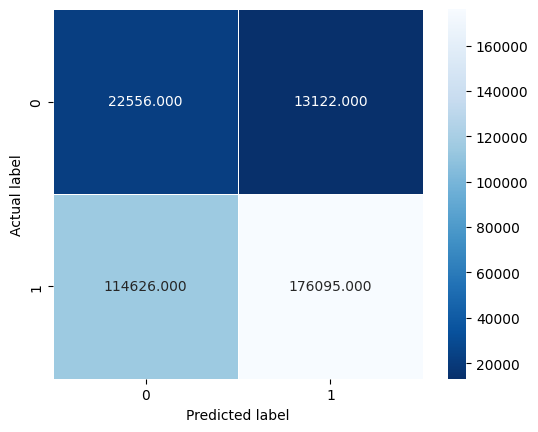

In [43]:
# Ahora la matriz de confusión
# 1. Para los datos de entrenamiento
predictions = regLog.predict(X_trainRenovada)
cm = metrics.confusion_matrix(y_train, predictions)
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');


Nota: Se refiere a la matriz de correlación respecto a lo predecido por el modelo y lo que realmente era.

Dada la informacion de la **Figura 9** podemos ver que para los datos de prueba el modelo acertó en a = 9670.000 y d = 75657.000 y no acertó en c = 48939.000 y b = 5620.000, lo que nos permite apreciar que es mayor el número de valores estimados de forma correcta por el modelo.

Figura 9

Matriz de correlación para los datos de prueba

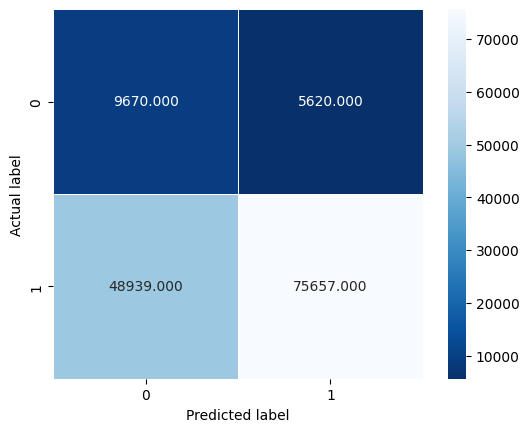

In [44]:
# 1.2 Para los datos de prueba
predictions = regLog.predict(X_testRenovada)
cm = metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

Nota: Se refiere a la matriz de correlación respecto a lo predecido por el modelo y lo que realmente era.

A continuación se va a analizar la probabilidad de incumplimiento de un usuario (Valor representado con 0). Inicialmente se realiza este proceso para los datos de entrenamiento, como se observa en la **Figura 10**

In [45]:
# Vamos a analizar la probabilidad de incumplimiento de un usuario (Este valor es representado con 0)
casoTrain = X_trainRenovada.copy()
casoTest = X_testRenovada.copy()
# Primero para los datos de entrenamiento
# Probabilidad de incumplimiento
probabilidadIncumplimiento = [round(elemento[0]*100,2) for elemento in regLog.predict_proba(X_trainRenovada)]
diccionarioCumplimiento = {0:"Incumplimiento",1:"Cumplimiento"}
RE = [diccionarioCumplimiento[elemento] for elemento in y_train]
RP = [diccionarioCumplimiento[elemento] for elemento in regLog.predict(X_trainRenovada)]
casoTrain["Probabilidad de incumplimiento"] = probabilidadIncumplimiento
casoTrain["Resultado Esperado"] = RE
casoTrain["Resultado predecido"] = RP


Como se puede apreciar en la **Figura 10** con los datos de entrenamiento de un total de 5 datos el modelo realizo un acierto en 3 de los 5 datos de entrenamiento entre los resultados esperados y los resultados predichos, otorgando un porcentaje de acierto del 60 % 

Figura 10 

Probabilidad de incumplimiento en los datos de entrenamiento

In [46]:
casoTrain.head()

,sub_grade C2,sub_grade F5,sub_grade D3,sub_grade E2,sub_grade D2,sub_grade C4,sub_grade B4,sub_grade B2,sub_grade D1,sub_grade A3,...,"dti (-0.04, 3.999]","dti (19.995, 23.994]","dti (11.997, 15.996]","dti (27.993, 31.992]","dti (3.999, 7.998]","dti (31.992, 35.991]","dti (35.991, 39.99]",Probabilidad de incumplimiento,Resultado Esperado,Resultado predecido
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.92,Incumplimiento,Incumplimiento
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.15,Incumplimiento,Incumplimiento
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.55,Cumplimiento,Incumplimiento
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60.35,Cumplimiento,Incumplimiento
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,58.26,Incumplimiento,Incumplimiento


Nota: Se encuentra también el resultado esperado y el resultado predecido por el modelo.

A continuación se va a analizar la probabilidad de incumplimiento de un usuario (Valor representado con 0 ), para los datos de prueba, como se puede observar en la **Figura 11**

In [47]:
# Ahora la probabilidad de incumplimiento para los datos de prueba
probabilidadIncumplimiento = [round(elemento[0]*100,2) for elemento in regLog.predict_proba(X_testRenovada)]
diccionarioCumplimiento = {0:"Incumplimiento",1:"Cumplimiento"}
RE = [diccionarioCumplimiento[elemento] for elemento in y_test]
RP = [diccionarioCumplimiento[elemento] for elemento in regLog.predict(X_testRenovada)]
casoTest["Probabilidad de incumplimiento"] = probabilidadIncumplimiento
casoTest["Resultado Esperado"] = RE
casoTest["Resultado predecido"] = RP

Figura 11

Probabilidad de incumplimiento en los datos de prueba

In [48]:
casoTest

,sub_grade C2,sub_grade F5,sub_grade D3,sub_grade E2,sub_grade D2,sub_grade C4,sub_grade B4,sub_grade B2,sub_grade D1,sub_grade A3,...,"dti (-0.04, 3.999]","dti (19.995, 23.994]","dti (11.997, 15.996]","dti (27.993, 31.992]","dti (3.999, 7.998]","dti (31.992, 35.991]","dti (35.991, 39.99]",Probabilidad de incumplimiento,Resultado Esperado,Resultado predecido
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.80,Cumplimiento,Cumplimiento
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,44.28,Cumplimiento,Cumplimiento
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,48.16,Cumplimiento,Cumplimiento
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,34.01,Cumplimiento,Cumplimiento
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.40,Cumplimiento,Cumplimiento
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.92,Cumplimiento,Incumplimiento
139882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,66.88,Cumplimiento,Incumplimiento
139883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,16.74,Cumplimiento,Cumplimiento
139884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,51.76,Cumplimiento,Incumplimiento


Nota: Se encuentra también el resultado esperado y el resultado predecido por el modelo.

Aquí se realiza el cálculo del credit score. Para ello se deben definir los límites del Scorecard, y posteriormente crear la tabla de cada variable con su respectivo coeficiente

In [49]:
# Calculo del credit score
# 1. Definir los limites del Scorecard
puntajeMinimo = 300
puntajeMaximo = 850
# 2. Crear la tabla de cada variable con su respectivo coeficiente
data = {"Variables":["Intercepto"]+list(X_trainRenovada.columns),"Coeficientes":[regLog.intercept_[0]]+list(regLog.coef_[0])}
scoreCardTabla = pd.DataFrame(data)

In [50]:
scoreCardTabla

,Variables,Coeficientes
0,Intercepto,-0.147451
1,sub_grade C2,-0.032223
2,sub_grade F5,-0.322845
3,sub_grade D3,0.071902
4,sub_grade E2,0.033750
...,...,...
74,"dti (11.997, 15.996]",0.024336
75,"dti (27.993, 31.992]",-0.161647
76,"dti (3.999, 7.998]",0.140404
77,"dti (31.992, 35.991]",-0.065240


Ahora se obtendrá lo que representa cada variable para el aumento del score y así sacar la suma de todos los coeficientes mínimos y máximos de cada categoría, esto se puede visualizar en la **Figura 12**.

In [51]:
sumaMaximaCoeficientes = 0
sumaMinimaCoeficientes = 0
listaCoeficientes = []
for i in range(len(scoreCardTabla)):
    listaCoeficientes.append(scoreCardTabla.loc[i,"Coeficientes"])
    j = i+1
    if j > 78:
        j = 0
    if scoreCardTabla.loc[j,"Variables"][:3] != scoreCardTabla.loc[i,"Variables"][:3]:
        sumaMaximaCoeficientes += max(listaCoeficientes)
        sumaMinimaCoeficientes += min(listaCoeficientes)
        listaCoeficientes = []


In [52]:
# Hora de calcular el score para cada variable
scoreCardTabla['Puntaje Crudo'] = scoreCardTabla['Coeficientes'] * (puntajeMaximo  - puntajeMinimo) / (sumaMaximaCoeficientes - sumaMinimaCoeficientes)
scoreCardTabla.loc[0, 'Puntaje Crudo'] = ((scoreCardTabla.loc[0,'Coeficientes'] - sumaMinimaCoeficientes) / (sumaMaximaCoeficientes - sumaMinimaCoeficientes)) * (550) + 300
# Se aproxima el puntaje para que este no quede en valores decimales
scoreCardTabla['Puntaje'] = scoreCardTabla['Puntaje Crudo'].round()

Figura 12

Coeficiente y puntaje representativo del scorecard de cada variable del modelo

In [53]:
# Realmente la suma se hará con el puntaje Crudo, el Puntaje será sólo como representación del aproximado
scoreCardTabla

,Variables,Coeficientes,Puntaje Crudo,Puntaje
0,Intercepto,-0.147451,586.218401,586.0
1,sub_grade C2,-0.032223,-3.310546,-3.0
2,sub_grade F5,-0.322845,-33.168330,-33.0
3,sub_grade D3,0.071902,7.387057,7.0
4,sub_grade E2,0.033750,3.467399,3.0
...,...,...,...,...
74,"dti (11.997, 15.996]",0.024336,2.500235,3.0
75,"dti (27.993, 31.992]",-0.161647,-16.607279,-17.0
76,"dti (3.999, 7.998]",0.140404,14.424745,14.0
77,"dti (31.992, 35.991]",-0.065240,-6.702651,-7.0


Nota: Los coeficientes se obtuvieron desde el modelo de la regresión logística

A continuación se procede a encontrar las variables que hacen más riesgosa a una persona, por lo que se procederá a buscar las variables que presenten un porcentaje negativo. Esto será realizado con el scorecard.

Figura 13

Variables riesgosas

In [54]:
# Se debe de buscar las variables cuyo puntaje sea negativo, luego se ordena del menor al mayor
# 1. Elegir sólo las variables cuyo puntaje sea menor a 0
variablesRiesgosas = scoreCardTabla[(scoreCardTabla['Puntaje'] < 0)][["Variables","Puntaje"]]
# 2. Ordenar de menor a mayor
variablesRiesgosas.sort_values(by=['Puntaje'])
# 3. Exponer estas variables en el reporte técnico

,Variables,Puntaje
43,purpose educational,-86.0
68,"int_rate (19.868, 21.932]",-75.0
61,"int_rate (17.804, 19.868]",-74.0
66,"int_rate (21.932, 23.996]",-71.0
42,grade G,-60.0
62,"int_rate (15.74, 17.804]",-57.0
50,purpose small_business,-55.0
37,grade F,-37.0
2,sub_grade F5,-33.0
33,sub_grade G3,-32.0


Nota: Se eligen las 10 primeras variables al ser las que menor puntaje tienen, son 35 variables con puntaje negativo en total.

In [55]:
# Veamos el puntaje maximo y minimo posible
sumaMaximaPuntaje= 0
sumaMinimaPuntaje = 0
listaPuntajes = []
for i in range(len(scoreCardTabla)):
    listaPuntajes.append(scoreCardTabla.loc[i,"Puntaje Crudo"])
    j = i+1
    if j > 78:
        j = 0
    if scoreCardTabla.loc[j,"Variables"][:3] != scoreCardTabla.loc[i,"Variables"][:3]:
        sumaMaximaPuntaje += max(listaPuntajes)
        sumaMinimaPuntaje += min(listaPuntajes)
        listaPuntajes = []

A continuación se procede a determinar, a partir del score si un usuario incumplirá o no con su crédito. Dado que la idea principal es utilizar los valores positivos, sólo se tendrán en cuenta dichos valores. Para este proceso se utilizarán los datos del test.

In [56]:
# Ahora vamos a ver el score que define si el usuario va a incumplir su credito o no
# 1. Vamos a calcular el false positive rate y el true positive rate
# Como la idea es con los positivos entonces sólo se toman estos casos
# (Vamos a usar los datos del test en este caso)
y_test_proba = regLog.predict_proba(X_testRenovada)[:][: , 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_proba)

Aquí será importante encontrar el mejor threshold que maximice el true positive rate y que minimice el falso positive rate. Nos apoyamos de la **Figura 14** para encontrar el mejor threshold.

Figura 14

Curva Característica Operativa del Receptor

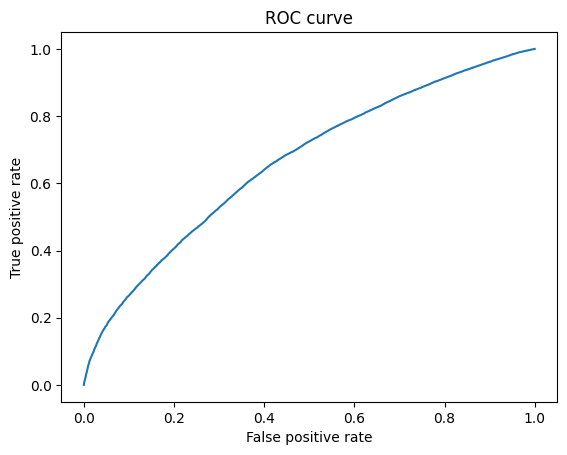

In [57]:
# Vamos a imprimir un plot para visualizar esto de una mejor forma
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');


Nota: El mejor threshold es 0.4804

In [58]:
# La idea es encontrar un threshold que maximice el true positive rate y que minimice el false positive rate
J = tpr - fpr
# El mejor threshold
mejorThreshold = thresholds[np.argmax(J)]
print("El mejor threshold es:",round(mejorThreshold,5))

El mejor threshold es: 0.4804


Ahora lo que se hace es traducir este threshold al score limite (Se va a aproximar a techo, para evitar problemas de elegir personas que no cumplen con el limite). Como se aprecia a continuación el puntaje limite para definir si un cliente incumplirá o no es de 594. 

In [59]:
scoreLimite = math.ceil(((math.log(mejorThreshold / (1 - mejorThreshold)) - sumaMinimaCoeficientes) * 
                       ((puntajeMaximo - puntajeMinimo) / (sumaMaximaCoeficientes - sumaMinimaCoeficientes)) + puntajeMinimo))
print("El puntaje limite para definir si un cliente incumplirá o no:",scoreLimite)

El puntaje limite para definir si un cliente incumplirá o no: 594


Obtenido el puntaje límite anterior, el cual permite saber si a un cliente se le deberá o no dar un crédito, se determina que se le negará el crédito a un cliente cuando éste presente un puntaje inferior a los 594.

In [60]:
# ¿De qué sirve este puntaje? Para conocer si se le debería de dar un credito a un cliente o no

In [61]:
puntaje = [round(sum(list(np.multiply([1]+list(casoTrain.loc[i,list(casoTrain.columns[:-3])]),list(scoreCardTabla['Puntaje Crudo']))))) for i in casoTrain.index]
casoTrain['Puntaje Crediticio'] = puntaje

In [62]:
creditoAceptado = ["Si" if casoTrain.loc[i,"Puntaje Crediticio"] >= scoreLimite else "No" for i in casoTrain.index]
casoTrain["Aceptar Credito"] = creditoAceptado

In [63]:
casoTrain.head()

,sub_grade C2,sub_grade F5,sub_grade D3,sub_grade E2,sub_grade D2,sub_grade C4,sub_grade B4,sub_grade B2,sub_grade D1,sub_grade A3,...,"dti (11.997, 15.996]","dti (27.993, 31.992]","dti (3.999, 7.998]","dti (31.992, 35.991]","dti (35.991, 39.99]",Probabilidad de incumplimiento,Resultado Esperado,Resultado predecido,Puntaje Crediticio,Aceptar Credito
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,67.92,Incumplimiento,Incumplimiento,524,No
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,73.15,Incumplimiento,Incumplimiento,498,No
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,63.55,Cumplimiento,Incumplimiento,544,No
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,60.35,Cumplimiento,Incumplimiento,558,No
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,58.26,Incumplimiento,Incumplimiento,567,No


In [64]:
puntaje = [round(sum(list(np.multiply([1]+list(casoTest.loc[i,list(casoTest.columns[:-3])]),list(scoreCardTabla['Puntaje Crudo']))))) for i in casoTest.index]
casoTest['Puntaje Crediticio'] = puntaje

In [65]:
creditoAceptado = ["Si" if casoTest.loc[i,"Puntaje Crediticio"] >= scoreLimite else "No" for i in casoTest.index]
casoTest["Aceptar Credito"] = creditoAceptado

In [66]:
casoTest.head()

,sub_grade C2,sub_grade F5,sub_grade D3,sub_grade E2,sub_grade D2,sub_grade C4,sub_grade B4,sub_grade B2,sub_grade D1,sub_grade A3,...,"dti (11.997, 15.996]","dti (27.993, 31.992]","dti (3.999, 7.998]","dti (31.992, 35.991]","dti (35.991, 39.99]",Probabilidad de incumplimiento,Resultado Esperado,Resultado predecido,Puntaje Crediticio,Aceptar Credito
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,48.80,Cumplimiento,Cumplimiento,606,Si
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,44.28,Cumplimiento,Cumplimiento,625,Si
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,48.16,Cumplimiento,Cumplimiento,609,Si
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,34.01,Cumplimiento,Cumplimiento,669,Si
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,49.40,Cumplimiento,Cumplimiento,604,Si


### Conclusiones

- Se pudo desarrollar un modelo, el cual permite al banco y al cliente, tener un puntaje para el cliente que desea obtener un crédito, con el fin de saber si es viable o no el desembolso del préstamo, donde puntajes inferiores a 594 determinan la  inviabilidad de dar el crédito, y donde puntajes mayores a ese valor determinan una alta probabilidad de cumplimiento para que el cliente pague a tiempo su crédito. 

- Por naturaleza del modelo, el banco podría perder clientes, y es probable que algunos sean catalogados como aquellos clientes morosos o que no presentan cumplimiento con sus responsabilidades financieras. No obstante, se puede tener más certeza de aquellos clientes en cuanto a su capacidad para cumplir con sus pendientes, lo que disminuye los riesgos para el banco que pueden darse en el momento de otorgar un crédito.

- En cuanto a la exactitud del modelo, así se tenga un valor del 61% tanto en el entrenamiento como en la validación, podría no ser suficiente dadas las necesidades del banco o la entidad, por lo que debería buscarse una forma de lograr un mejor porcentaje. Esto puede darse, por ejemplo, con el uso de más datos, o con una forma de manejo distinta de la base datos, como realizar, en un principio, el tratamiento de los valores no definidos o perdidos (para evitar la eliminación de filas que los contengan).

### Referencia de donde se obtuvo información de apoyo.
* https://empresas.blogthinkbig.com/como-interpretar-la-matriz-de-confusion-ejemplo-practico/#:~:text=La%20matriz%20de%20confusi%C3%B3n%20es,con%20distintos%20tipos%20de%20error.
* https://www.listendata.com/2019/08/credit-risk-modelling.html
* http://www.rincondepaco.com.mx/rincon/Inicio/Apuntes/Proyecto/archivos/Documentos/Chi.pdf



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=91f8b4f2-8330-4992-be0f-ec36d589e197' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>